<a href="https://colab.research.google.com/github/sanhith-lab/generative_ai_2251/blob/main/Gen_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/Brain MRI Images.zip") as zip_ref:
    zip_ref.extractall()

os.listdir("Brain MRI Images")


In [ ]:
train_dir = 'Brain MRI Images/Train'
val_dir = 'Brain MRI Images/Validation'


In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=10)
model.save("brain_tumor_cnn_model.h5")


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step - accuracy: 0.5974 - loss: 0.8222 - val_accuracy: 0.6750 - val_loss: 0.6683
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 950ms/step - accuracy: 0.6227 - loss: 0.6611 - val_accuracy: 0.6875 - val_loss: 0.5899
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 883ms/step - accuracy: 0.7129 - loss: 0.5690 - val_accuracy: 0.7625 - val_loss: 0.5288
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.7743 - loss: 0.4644 - val_accuracy: 0.8375 - val_loss: 0.4017
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 883ms/step - accuracy: 0.8718 - loss: 0.3130 - val_accuracy: 0.8875 - val_loss: 0.3347
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 930ms/step - accuracy: 0.9028 - loss: 0.2370 - val_accuracy: 0.9000 - val_loss: 0.2785
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.9330 - loss: 0.2240 - val_accuracy: 0.9375 - val_loss: 0.2320
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.9627 - loss: 0.1204 - val_accuracy: 0.8375 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


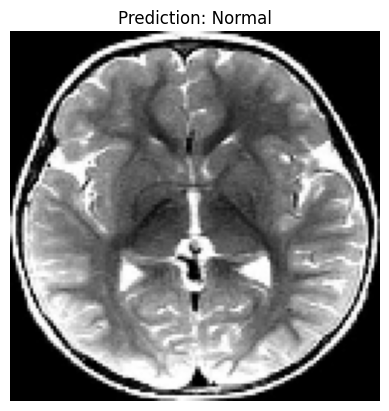

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
img_path = "/content/Normal (1).jpg"
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title("Prediction: " + ("Tumor Detected" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Paths
data_dir = "/content/Brain MRI Images.zip"
classes = ["Normal", "Tumor"]

# Parameters
img_size = (64, 64)  # resize images
sequence_length = img_size[0]  # for LSTM time steps

# Load images and labels
X = []
y = []

for idx, label in enumerate(classes):
    folder = os.path.join(data_dir, label)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = load_img(img_path, target_size=img_size, color_mode="grayscale")
        img_array = img_to_array(img) / 255.0
        img_array = img_array.reshape(sequence_length, -1)  # flatten image into sequence
        X.append(img_array)
        y.append(idx)

X = np.array(X)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
